# Import modules and libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import networkx as nx
import os
import plotly.express as px
from fink_utils.photometry.conversion import dc_mag
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from datetime import datetime
from scipy.optimize import curve_fit
import copy
from gatspy import periodic
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import datetime

In [3]:
liste = [
    'EB*', 'Mira', 'SN candidate', 'QSO', 'BLLac', 'Blazar',
    'Ambiguous','RRLyr', 'YSO', 'LPV*', 'AGN','Seyfert_1', 'AGN_Candidate', 'TTau*', 'Kilonova candidate'
] 
#deleted 'Early SN Ia candidate', 'Microlensing candidate'

#define df as an empty dataframe
df = pd.DataFrame()

dossier = '/home/centos/data/data_march'
name = {}
count = 0
for nom_fichier in liste:
    chemin = os.path.join(dossier, "finkclass=" + nom_fichier)

    temp = pd.read_parquet([chemin + "/" + os.listdir(chemin)[i] for i in range(min(10, len(os.listdir(chemin))))])

    #add a column with the name of the file
    name[nom_fichier.split('=')[-1]] = count
    count += 1
    
    #concatenate the dataframes
    df = pd.concat([df, temp], ignore_index=True)

kilonova = pd.read_parquet('/home/centos/data/balanced_data/finkclass=Kilonova candidate')
ambiguous = pd.read_parquet('/home/centos/data/balanced_data/finkclass=Ambiguous')
SN = pd.read_parquet('/home/centos/data/balanced_data/finkclass=SN candidate')

#Add a column 'finkclass' with the value Kilonova candidate
kilonova['finkclass'] = 'Kilonova candidate'
ambiguous['finkclass'] = 'Ambiguous'
SN['finkclass'] = 'SN candidate'
df = pd.concat([df, kilonova, ambiguous, SN], ignore_index=True)


<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject


In [4]:
variable_star_class = ['EB*', 'Mira', 'RRLyr', 'YSO', 'LPV*', "TTau*"]
AGN_class = ['QSO', 'BLLac', 'Blazar', 'AGN', 'Seyfert_1', 'AGN_Candidate']

def define_meta_class(ele):
    if ele in variable_star_class:
        ele = "Variable Star"

    elif ele in AGN_class:
        ele = "AGN"

    return ele

#for every items in df change the value of the column 'finkclass' by applying the function define_meta_class
df['finkclass'] = df['finkclass'].apply(define_meta_class)

df = df.groupby('finkclass').head(200)
df = df.reset_index(drop=True)


In [5]:
# extract columns of interest
cols = [
    'rf_kn_vs_nonkn',
    'rf_snia_vs_nonia',
    'snn_sn_vs_all',
    'snn_snia_vs_nonia'
]


cols_in_candidate = [
    'jdstarthist',
    'magpsf',
    'sigmapsf',
    'fid', 
    'magnr', 
    'sigmagnr', 
    'isdiffpos',
    'neargaia',
    'sgscore1',
    'classtar'
]



### Alerts

In [6]:
import requests
import pandas as pd
import io
# get data for ZTF19acnjwgm
r = requests.post(
    'https://fink-portal.org/api/v1/objects',
    json={
        'objectId': 'ZTF23aaaatwl',
        'withupperlim': True,
        'output-format': 'json'
    }
)

pdf = pd.read_json(io.BytesIO(r.content))

temp = []

for col in cols:
    temp.append('d:' + col)

for col in cols_in_candidate:
    temp.append('i:' + col)

from fink_science.ad_features.processor import extract_features_ad_raw

def extract(pdf):
    # moment de la detection d'anomalie
    t0 = pdf[pdf['d:anomaly_score'] == np.min(pdf['d:anomaly_score'])]['i:jd'].values[0]

    # donnees 30 jours avant l'anomalie
    pdf_anomalous = pdf[(pdf['i:jd'] >= t0 - 30) & (pdf['i:jd'] <= t0)]

    if type(pdf['i:objectId']) != str:
        id = pdf['i:objectId'].values[0]

    else:
        id = pdf['i:objectId']

    features = extract_features_ad_raw(
    pdf['i:magpsf'], 
    pdf['i:jd'], 
    pdf['i:sigmapsf'], 
    pdf['i:fid'], 
    id
    )

    #create a df with every element of the dictionnary located in df['lc_features_g']
    if 1 in features:
        green = pd.DataFrame([features[1]])

    else:
        green = pd.DataFrame()

    #create a df with every element of the dictionnary located in df['lc_features_g']
    if 2 in features:
        red = pd.DataFrame([features[2]])

    else:
        red = pd.DataFrame()

    #rename every column of df_lc_features_g and df_lc_features_r by adding _g and _r after
    green = green.add_suffix('_g')
    red = red.add_suffix('_r')

    return pd.concat([green, red], axis=1)

to_add = pdf[temp][pdf['d:anomaly_score'] == np.min(pdf['d:anomaly_score'])]
to_add = to_add.reset_index(drop=True)

anomaly = pd.concat([to_add, extract(pdf)], axis=1)

In [7]:
r = requests.post(
  'https://fink-portal.org/api/v1/anomaly',
  json={
    'n': 10, # Optional. Number of objects to retrieve between `stop_date` and `start_date`. Default is 10.
    'start_date': "2023-06-15", # Optional. YYYY-MM-DD. Default is 2023-01-25
    'stop_date': "2023-06-27", # Optional. YYYY-MM-DD. Default is today
    'output-format': 'json'
  }
)

# Format output in a DataFrame
oids = [i['i:objectId'] for i in r.json()]

# retrieve full objects data
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': ','.join(oids),
    'output-format': 'json'
  }
)


# Format output in a DataFrame
pdf = pd.read_json(io.BytesIO(r.content))

#create sub dataframe for every unique object_id
sous_datasets = []
for value in pdf['i:objectId'].unique():
    sous_datasets.append(pdf[pdf['i:objectId'] == value].copy())

for i in range(len(sous_datasets)):
  to_add = sous_datasets[i][temp][sous_datasets[i]['d:anomaly_score'] == np.min(sous_datasets[i]['d:anomaly_score'])]
  to_add = to_add.reset_index(drop=True)
  features = extract(sous_datasets[i])
  to_add = pd.concat([to_add, features], axis=1)
  anomaly = pd.concat([anomaly, to_add], axis = 0)

#add an index on anomaly
anomaly = anomaly.reset_index(drop=True)

#when a column start with a letter and then :, suppress the letter and the :
anomaly.columns = [col[2:] if col[1] == ':' else col for col in anomaly.columns]

# PCA

In [8]:
#extract columns of interest in df
df_filt = df[cols]

#create a df with the columns of interest in candidate which are located in df['candidate']
df_candidate = pd.DataFrame(df['candidate'].tolist(), columns=cols_in_candidate)

#create a df with every element of the dictionnary located in df['lc_features_g']
df_lc_features_g = pd.DataFrame(df['lc_features_g'].tolist())

#create a df with every element of the dictionnary located in df['lc_features_g']
df_lc_features_r = pd.DataFrame(df['lc_features_r'].tolist())

#rename every column of df_lc_features_g and df_lc_features_r by adding _g and _r after
df_lc_features_g = df_lc_features_g.add_suffix('_g')
df_lc_features_r = df_lc_features_r.add_suffix('_r')

#concatenate the two dataframes
df_filt = pd.concat([df_filt, df_candidate, df_lc_features_g, df_lc_features_r], axis=1)

#in the column isdiffpos, replace t by 1 and f by -1
df_filt['isdiffpos'] = df_filt['isdiffpos'].replace({'t': 1, 'f': -1})
anomaly['isdiffpos'] = anomaly['isdiffpos'].replace({'t': 1, 'f': -1})

#Normalizing data
anomaly = (anomaly - df_filt.mean()) / df_filt.std()
df_filt = (df_filt - df_filt.mean()) / df_filt.std()

#replace None or NaN by 0
anomaly = anomaly.fillna(0)
df_filt = df_filt.fillna(0)

#do a pca and show variance explained
n_components = 20

pca = PCA(n_components=n_components)
pca.fit(df_filt)

#select the variable with the highest absolute value in the first principal component
max_ind = np.argmax(np.abs(pca.components_[0]))

#select variable with a high absolute value of at least half of the principal component with the highest absolute value
selected_variables = df_filt.columns[np.abs(pca.components_[0]) > np.abs(pca.components_[0][max_ind]/2)]

#create a new df with the selected variables
df_filt_selected = df_filt[selected_variables]
anomaly_filt_selected = anomaly[selected_variables]


label = df['finkclass']

In [9]:
len(df)

986

In [10]:
#take a random sample of 100 elements in df_filt_selected and label
df_filt_selected_sample = df_filt_selected.sample(n=len(df) - 200, random_state=42)
label_sample = label[df_filt_selected_sample.index]

#create an other sample with 100 different elements of df_filt_selected and label
df_filt_selected_sample2 = df_filt_selected.drop(df_filt_selected_sample.index)
df_filt_selected_sample2 = df_filt_selected_sample2.sample(n=200, random_state=42)
label_sample2 = label[df_filt_selected_sample2.index]

In [11]:
#creating a X_train containing all pair of X_train
X_train = []
y_train = []
for i in range(len(df_filt_selected_sample)):
    for j in range(i+1, len(df_filt_selected_sample)):
        X_train.append([df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()])
        y_train.append(1 if label_sample.iloc[i] == label_sample.iloc[j] else 0)

X_test = []
y_test = []
for i in range(len(df_filt_selected_sample)):
    for j in range(i+1, len(df_filt_selected_sample)):
        X_test.append([df_filt_selected_sample.iloc[i].to_list(), df_filt_selected_sample.iloc[j].to_list()])
        y_test.append(1 if label_sample.iloc[i] == label_sample.iloc[j] else 0)

In [12]:
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    
    def __len__(self):
        return self.length

trainset = dataset(X_train, y_train)
#DataLoader
trainloader = DataLoader(trainset, batch_size=64, shuffle=False)

testset = dataset(X_test, y_test)
#DataLoader
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [13]:
#create a neural network that take a element of X_train with size (2, 22) and predict the labels with a fc layer with 22 neurons

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        nb_variables = len(selected_variables)
        self.stack = nn.Sequential(nn.Linear(2*nb_variables, 4*nb_variables),
        nn.ReLU(),
        nn.Linear(4*nb_variables, 8*nb_variables),
        nn.ReLU(),
        nn.Linear(8*nb_variables, 4*nb_variables),
        nn.ReLU(),
        nn.Linear(4*nb_variables, 2*nb_variables),
        nn.ReLU(),
        nn.Linear(2*nb_variables, 1),
        nn.Sigmoid())

    def forward(self, x):
        x = x.view(-1, 2*len(selected_variables))
        x = self.stack(x)

        return x

net = Net()

#print the archetecture of the neural network
print(net)

#print the number of parameters
print(sum(p.numel() for p in net.parameters() if p.requires_grad))

Net(
  (stack): Sequential(
    (0): Linear(in_features=36, out_features=72, bias=True)
    (1): ReLU()
    (2): Linear(in_features=72, out_features=144, bias=True)
    (3): ReLU()
    (4): Linear(in_features=144, out_features=72, bias=True)
    (5): ReLU()
    (6): Linear(in_features=72, out_features=36, bias=True)
    (7): ReLU()
    (8): Linear(in_features=36, out_features=1, bias=True)
    (9): Sigmoid()
  )
)
26281


In [14]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred[:,0], y)

        # Backpropagation (always in three steps)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch %1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred[:,0], y).item()
            pred = torch.tensor([1 if pred[i] > 0.5 else 0 for i in range(len(pred))])
            correct += (pred == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return 100*(1-correct)

In [15]:
# Hyperparameters
learning_rate = 0.001
epochs = 500
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)

In [16]:
error = []

for t in range(epochs):
    print(f"Epoch {t+1}-----------------")
    # Use train_loop and test_loop functions
    train_loop(trainloader, net, loss_fn, optimizer)
    x = test_loop(testloader, net, loss_fn)
    error.append(x)




print("Done!")

Epoch 1-----------------
loss: 0.726885  [    0/308505]
loss: 0.260010  [64000/308505]
loss: 0.278174  [128000/308505]
loss: 0.189058  [192000/308505]
loss: 0.227405  [256000/308505]
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.295649
Epoch 2-----------------
loss: 0.416310  [    0/308505]
loss: 0.292963  [64000/308505]
loss: 0.267890  [128000/308505]
loss: 0.151329  [192000/308505]
loss: 0.194153  [256000/308505]
Test Error: 
 Accuracy: 86.1%, Avg loss: 0.262604
Epoch 3-----------------
loss: 0.382396  [    0/308505]
loss: 0.149417  [64000/308505]
loss: 0.233239  [128000/308505]
loss: 0.145593  [192000/308505]
loss: 0.171053  [256000/308505]
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.245858
Epoch 4-----------------
loss: 0.317855  [    0/308505]
loss: 0.198561  [64000/308505]
loss: 0.240131  [128000/308505]
loss: 0.147891  [192000/308505]
loss: 0.165238  [256000/308505]
Test Error: 
 Accuracy: 87.8%, Avg loss: 0.240520
Epoch 5-----------------
loss: 0.322298  [    0/308505]
loss: 0.2219

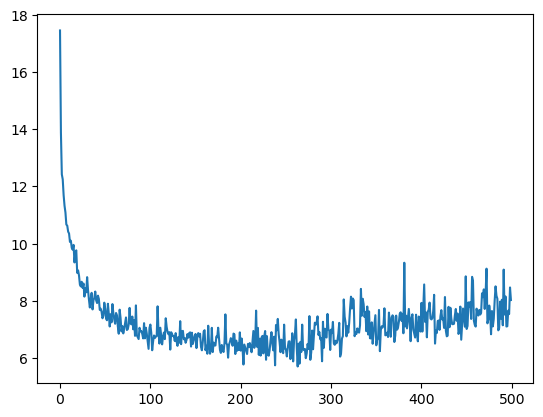

In [19]:
plt.plot(error)

torch.save(net.state_dict(), 'results/models/bigger model.pt')
np.savetxt('results/models/bigger model.csv', error, delimiter=',')




# Plot the graph

In [21]:
name_meta = {'Variable Star': 0,
 'AGN': 1,
 'SN candidate': 2,
 'Ambiguous': 3,
 'Kilonova candidate': 4}

#create a list with len(name) different colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(name_meta)))

#for every key in the dictionnary name, change name[key] by colors[ind]
for ind, key in enumerate(name_meta):
    name_meta[key] = colors[ind]

Ano7 is linked with 17 Variable Star
17 anomaly edges added over 40000 possible edges ie 0 %
0 anomaly edges added over 55 possible edges ie 0 %
64 has no edges
134 has no edges
397 has no edges
270 has no edges
418 has no edges
833 has no edges
699 has no edges
701 has no edges
698 has no edges
427 has no edges
681 has no edges
Ano0 has no edges
Ano1 has no edges
Ano2 has no edges
Ano3 has no edges
Ano4 has no edges
Ano5 has no edges
Ano6 has no edges
Ano8 has no edges
Ano9 has no edges
Ano10 has no edges


/home/centos/anaconda3/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


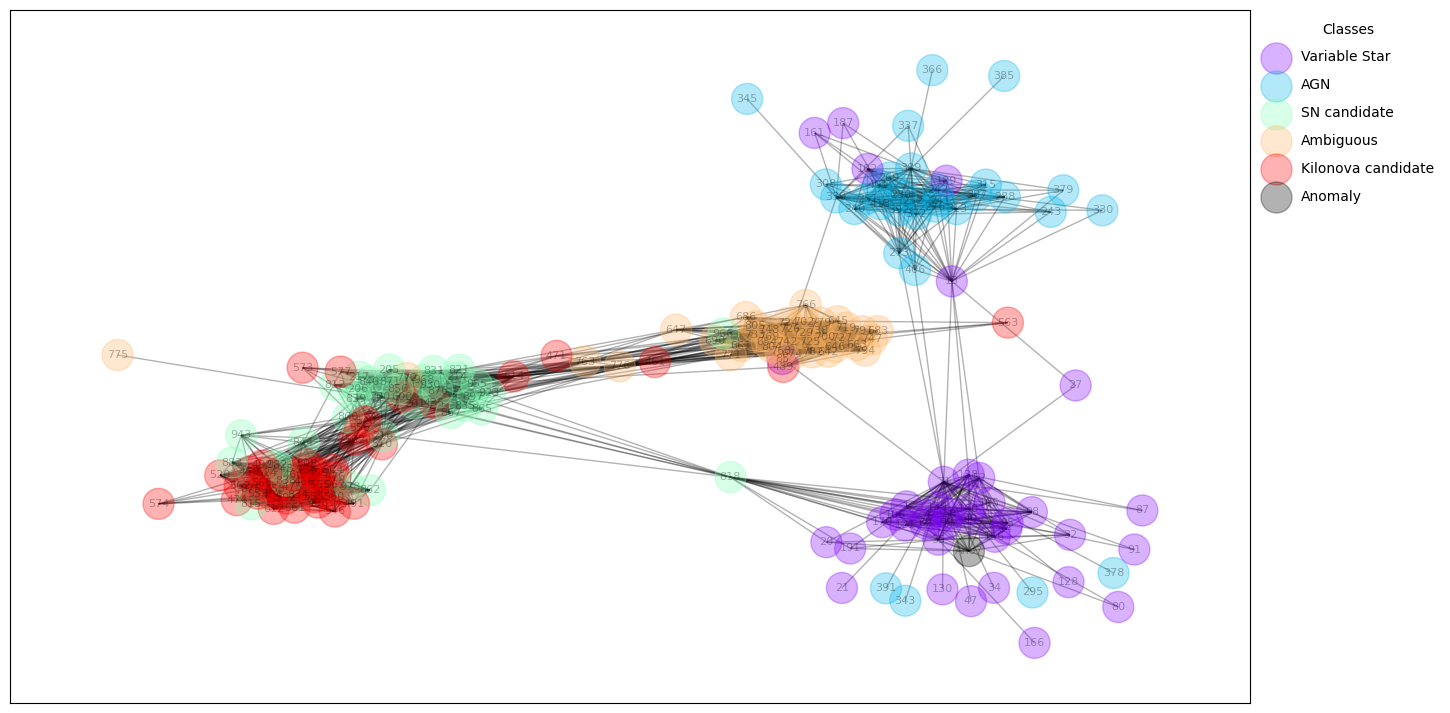

In [22]:
#defining the graph
G = nx.Graph()

#defining colors
plt.figure(figsize=(16,9))
color_map = []

#change color of each node according to their type
G.add_nodes_from(df_filt_selected_sample2.index)

for node in G: 
    ele = name_meta[df['finkclass'][node]]
    color_map.append(ele)

for ind, key in enumerate(name_meta):
    plt.scatter([],[], color=name_meta[key], alpha=0.3, s=500, label=key)

#add edges
dict_edges = {}
for i in range(len(df_filt_selected_sample2) + len(anomaly)):
    dict_edges[i] = {}
    
for i in range(len(df_filt_selected_sample2)):
    
    for j in range(i+1, len(df_filt_selected_sample2)):
        pred = float(net(torch.tensor([[df_filt_selected_sample2.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))
        if pred > 0.5:
            G.add_edge(df_filt_selected_sample2.index[i], df_filt_selected_sample2.index[j])
            

            dict_edges[i][j] = pred
            dict_edges[j][i] = pred


#adding anomaly edges
plt.scatter([],[], color="black", alpha=0.3, s=500, label="Anomaly")

count = 0
for i in range(len(anomaly)):
    G.add_node("Ano" + str(i))
    color_map.append("black")
    count_meta = {'Variable Star': 0,
            'AGN': 0,
            'SN candidate': 0,
            'Ambiguous': 0,
            'Kilonova candidate': 0}
    for j in range(len(df_filt_selected_sample2)):
        pred = float(net(torch.tensor([[anomaly_filt_selected.iloc[i].to_list(), df_filt_selected_sample2.iloc[j].to_list()]], dtype=torch.float32)))

        if pred > 0.5:
            G.add_edge("Ano" + str(i), df_filt_selected_sample2.index[j])
            

            dict_edges[len(df_filt_selected_sample2) + i][j] = pred
            dict_edges[j][len(df_filt_selected_sample2) + i] = pred

            count_meta[df['finkclass'][df_filt_selected_sample2.index[j]]] += 1

    for key, ind in count_meta.items():
        if ind != 0:
            print("Ano" + str(i), "is linked with", ind, key)

    count += sum(count_meta.values())

print(count, "anomaly edges added over", int(len(df_filt_selected_sample2)**2), "possible edges ie", int((count/len(df_filt_selected_sample2)**2)*100), "%")

count = 0          
for i in range(len(anomaly)):
    for j in range(i + 1, len(anomaly)):

        pred = float(net(torch.tensor([[anomaly_filt_selected.iloc[i].to_list(), anomaly_filt_selected.iloc[j].to_list()]], dtype=torch.float32)))

        if pred > 0.5:
            G.add_edge("Ano" + str(i), "Ano" + str(j))
            

            dict_edges[len(df_filt_selected_sample2) + i][len(df_filt_selected_sample2) + j] = pred
            dict_edges[len(df_filt_selected_sample2) + j][len(df_filt_selected_sample2) + i] = pred
            count += 1
            print("Ano" + str(i), "Ano" + str(j), "are linked !")

print(count, "anomaly edges added over", int(len(anomaly) * (len(anomaly) - 1) / 2), "possible edges ie", int((count/(len(anomaly) * (len(anomaly) - 1) / 2)*100)), "%")

#filtering the nodes without edges
nodes_with_edges = []
filtered_color = []
i = 0

at_least_one = False
for node in G.nodes():
    at_least_one = False
    if len(G.edges(node)) > 0:
        nodes_with_edges.append(node)
        filtered_color.append(color_map[i])
        at_least_one = True

    if not at_least_one:
        print(node, "has no edges")
    

    i += 1

nx.draw_networkx(G, with_labels=True, nodelist=nodes_with_edges, node_color=filtered_color, node_size=500, alpha=0.3, font_size=8)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Classes', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()